In [1]:
from matplotlib import pyplot as plt

import torch

import pyro
from pyro.infer.mcmc import MCMC
import pyro.distributions as dist
from pyro.infer.mcmc import HMC as HMC_Pyro

from hmc import HMC as HMC_Local
from sghmc import SGHMC as SGHMC_Local

In [2]:
pyro.clear_param_store()

pyro.set_rng_seed(101)

# create some data with 6 observed heads and 4 observed tails
x1 = torch.ones(10)
x1[0:6] = torch.zeros(6)

x2 = torch.ones(10)
x2[0:2] = torch.zeros(2)

    
def model(x1, x2, alpha0=1., beta0=1.):
    alpha0 = torch.tensor(alpha0)
    beta0 = torch.tensor(beta0)
    
    f1 = pyro.sample("coin1", dist.Beta(alpha0, beta0))
    f2 = pyro.sample("coin2", dist.Beta(alpha0, beta0))
    
    return pyro.sample("obs1", dist.Bernoulli(f1), obs=x1), pyro.sample("obs2", dist.Bernoulli(f2), obs=x2)

In [3]:
hmc_local = HMC_Local(model, step_size=0.75, num_steps=4)
mcmc_local = MCMC(hmc_local, num_samples=1000)
mcmc_local.run(x1, x2)
samples_local = mcmc_local.get_samples()

Sample: 100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [00:17, 115.19it/s]


In [4]:
BATCH_SIZE = 5

sghmc_local = SGHMC_Local(model, subsample_positions=[0, 1] ,batch_size=BATCH_SIZE, step_size=0.1, num_steps=4, with_friction=True, do_mh_correction=False)
#perm = torch.randperm(data.size(0))
#idx = perm[:BATCH_SIZE]
#mini_batch = data[idx]    
sg_mcmc_local = MCMC(sghmc_local, num_samples=1000)
sg_mcmc_local.run(x1, x2)
sg_samples_local = sg_mcmc_local.get_samples()

Sample: 100%|███████████████████████████████████████████████████████████████████████████| 2000/2000 [00:17, 113.18it/s]


In [5]:
hmc_pyro = HMC_Pyro(model)
mcmc_pyro = MCMC(hmc_pyro, num_samples=1000)
mcmc_pyro.run(x1, x2)
samples_pyro = mcmc_pyro.get_samples()

Sample: 100%|███████████████████████████████████████| 2000/2000 [00:33, 60.51it/s, step size=8.73e-01, acc. prob=0.968]


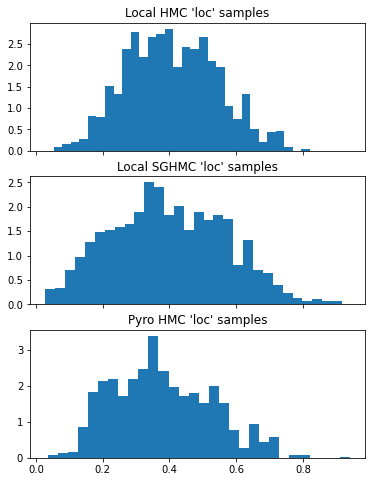

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True)
with torch.no_grad():
    axs[0].hist(samples_local["coin1"].numpy(), density=True, bins=30)
    axs[0].set(title="Local HMC 'loc' samples")
    axs[1].hist(sg_samples_local["coin1"].numpy(), density=True, bins=30)
    axs[1].set(title="Local SGHMC 'loc' samples")
    axs[2].hist(samples_pyro["coin1"].numpy(), density=True, bins=30)
    axs[2].set(title="Pyro HMC 'loc' samples")
plt.show()
#posterior samples should look like a beta(5, 7) dist

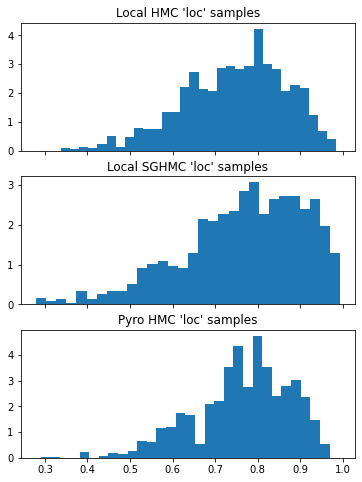

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(6, 8), sharex=True)
with torch.no_grad():
    axs[0].hist(samples_local["coin2"].numpy(), density=True, bins=30)
    axs[0].set(title="Local HMC 'loc' samples")
    axs[1].hist(sg_samples_local["coin2"].numpy(), density=True, bins=30)
    axs[1].set(title="Local SGHMC 'loc' samples")
    axs[2].hist(samples_pyro["coin2"].numpy(), density=True, bins=30)
    axs[2].set(title="Pyro HMC 'loc' samples")
plt.show()
#posterior samples should look like a beta(9, 3) dist